In [2]:
from utils import *
from map_utils import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    WhiteKernel,
    ExpSineSquared,
    RationalQuadratic,
)
import pickle
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)
import numpy as np
import seaborn as sns
import matplotlib
import shapely
from matplotlib.colors import LogNorm

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


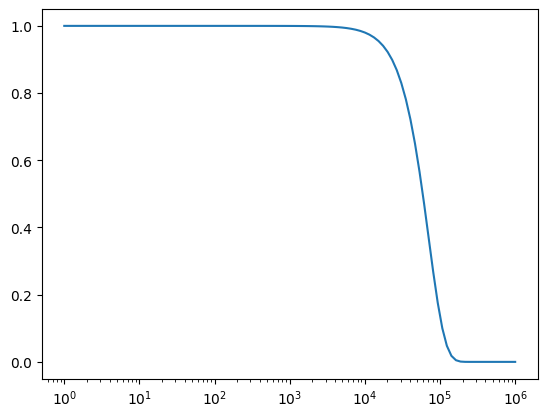

In [ ]:
X = np.logspace(0, 6, 100)
plt.plot(X, rbf(X, 5e4, 1.0))
plt.xscale("log")

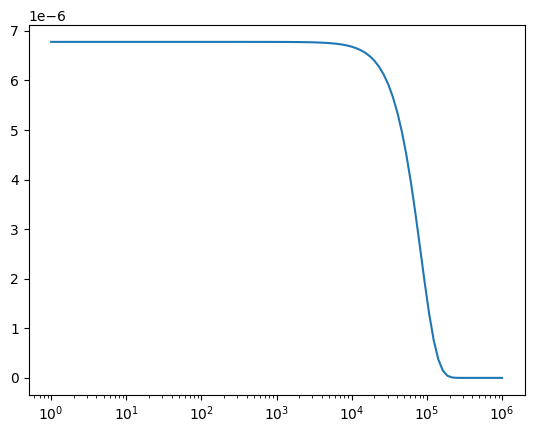

In [ ]:
X = np.logspace(0, 6, 100)
plt.plot(X, gaussian(X, 0, 2.355 * 2.5e4))
plt.xscale("log")

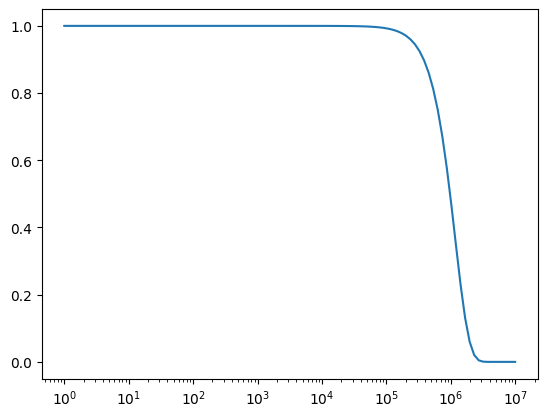

In [ ]:
X = np.logspace(0, 7, 100)
plt.plot(X, rbf(X, 8.28e5, 1.0))
plt.xscale("log")

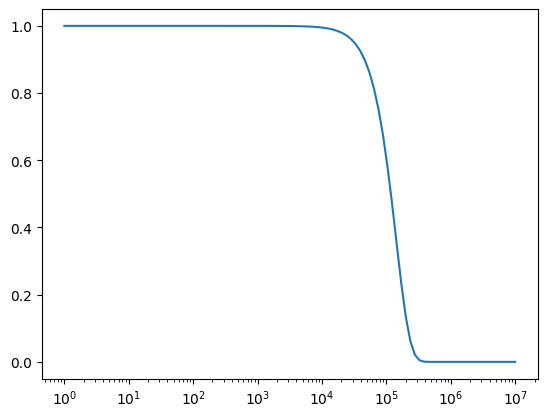

In [ ]:
X = np.logspace(0, 7, 100)
plt.plot(X, rbf(X, 1e5, 1.0))
plt.xscale("log")

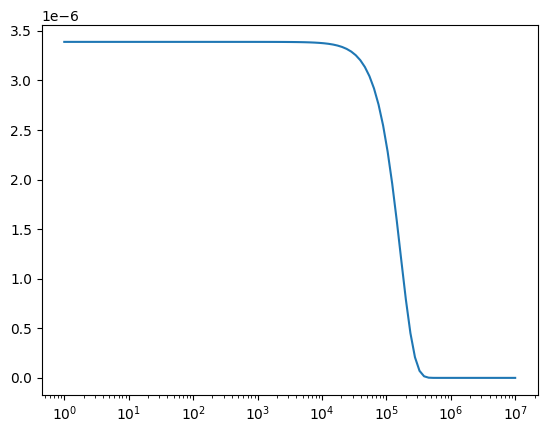

In [ ]:
X = np.logspace(0, 7, 100)
plt.plot(X, gaussian(X, 0, 2.355 * 5e4))
plt.xscale("log")

# aetri


In [ ]:
gp = pickle.load(open(f"./models/world.pkl", "rb"))

## aetitr


In [ ]:
gp.kernel_

1.12**2 * RBF(length_scale=[8.28e+05, 6.14e+05]) + WhiteKernel(noise_level=1.18)

In [6]:
from utils import *
from map_utils import *
from models import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    WhiteKernel,
    RationalQuadratic,
)
import pickle
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)
import numpy as np
import seaborn as sns
import matplotlib
import shapely
from matplotlib.colors import LogNorm
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.compose import TransformedTargetRegressor

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 500000.0. Decreasing the bound

0.314**2 * RBF(length_scale=[5e+04, 5e+04]) + 0.162**2 * RBF(length_scale=[1.83e+05, 2.93e+05]) + 0.164**2 * RBF(length_scale=[5e+05, 5.76e+05]) + WhiteKernel(noise_level=0.883)
Training RMSE: 61.09641429927832
 Training MAE 24.28312381747242
Validation RMSE: 61.774041315015644
 Validation MAE 25.952724263421928


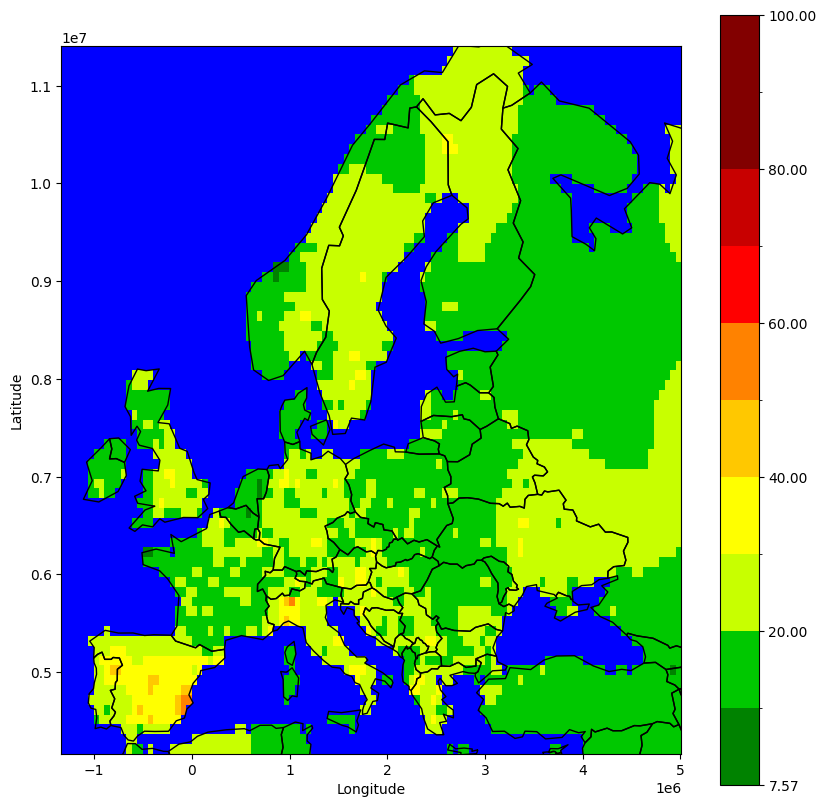

/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 1000000.0. Increasing the boun

0.319**2 * RBF(length_scale=[5e+04, 5e+04]) + 0.192**2 * RBF(length_scale=[2.01e+05, 3.04e+05]) + 0.311**2 * RBF(length_scale=[1e+06, 1e+06]) + WhiteKernel(noise_level=0.886)
Training RMSE: 66.7072704117254
 Training MAE 25.26602638016309
Validation RMSE: 71.6226544519805
 Validation MAE 27.12933776716772


In [7]:
regions = ['europe', 'world']
for region in regions:
    _, training, validation = get_from_region(region=region)

    X = training[["lon", "lat"]].values
    y = training["wait"].values

    log_transformer = get_log_transformer()
    y_transformed = log_transformer.fit_transform(y)

    sigma = np.std(y_transformed)

    rbf = RBF(
        length_scale=[5e4, 5e4], length_scale_bounds=(5e4, 1e5)
    )
    rbf2 = RBF(
        length_scale=[1e5, 1e5], length_scale_bounds=(1e5, 5e5)
    )
    rbf3 = RBF(
        length_scale=[5e5, 5e5], length_scale_bounds=(5e5, 1e6)
    )

    kernel = (
        ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e1)) * rbf
        + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf2
        + ConstantKernel(constant_value=sigma**2, constant_value_bounds=(1e-2, 1e2)) * rbf3
        + WhiteKernel(noise_level=1.05e0, noise_level_bounds=(1e-1, 1e1))
    )


    gpr = get_optimized_gpr(kernel, X, y)
    print(gpr.regressor_.kernel_)
    evaluate(gpr, train=training, validation=validation)
    map_from_model(gpr, region=region)